## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [446]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder


In [447]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [448]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [449]:
import pandas as pd

# 데이터 로드
train = pd.read_csv('../data/train.csv').drop(columns=['ID'])
test = pd.read_csv('../data/test.csv').drop(columns=['ID'])

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형', '특정_시술_유형',
       '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부', '난자

In [450]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 68 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술_시기_코드               256351 non-null  object 
 1   시술_당시_나이               256351 non-null  object 
 2   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 3   시술_유형                  256351 non-null  object 
 4   특정_시술_유형               256349 non-null  object 
 5   배란_자극_여부               256351 non-null  int64  
 6   배란_유도_유형               256351 non-null  object 
 7   단일_배아_이식_여부            250060 non-null  float64
 8   착상_전_유전_검사_사용_여부       2718 non-null    float64
 9   착상_전_유전_진단_사용_여부       250060 non-null  float64
 10  남성_주_불임_원인             256351 non-null  int64  
 11  남성_부_불임_원인             256351 non-null  int64  
 12  여성_주_불임_원인             256351 non-null  int64  
 13  여성_부_불임_원인             256351 non-null  int64  
 14  부부_주_불임_원인             256351 non-nu

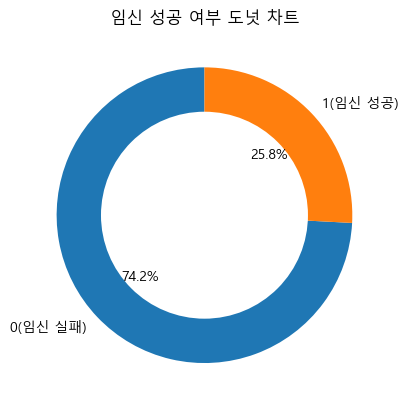

In [451]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [452]:
# '난자_출처' 변수의 값이 '알수없음'에 해당하는 데이터 추출
unknown_train = train[train['난자_출처'] == '알 수 없음']
unknown_test = test[test['난자_출처'] == '알 수 없음']

# 새로운 데이터셋 생성
print("난자_출처가 '알수없음'인 데이터셋:")
print(unknown_train)

난자_출처가 '알수없음'인 데이터셋:
       시술_시기_코드 시술_당시_나이  임신_시도_또는_마지막_임신_경과_연수 시술_유형 특정_시술_유형  배란_자극_여부  \
14       TRXQMD  만38-39세                    NaN    DI      IUI         0   
39       TRDQAZ  만18-34세                    NaN    DI      IUI         1   
127      TRJXFG  만35-37세                    NaN    DI      IUI         1   
162      TRXQMD  만38-39세                    NaN    DI      IUI         1   
174      TRCMWS  만40-42세                    NaN    DI      IUI         0   
...         ...      ...                    ...   ...      ...       ...   
256174   TRZKPL  만45-50세                    NaN    DI      IUI         1   
256222   TRYBLT  만18-34세                    NaN    DI      IUI         1   
256228   TRYBLT  만40-42세                    NaN    DI      IUI         1   
256301   TRCMWS  만40-42세                    NaN    DI      IUI         0   
256326   TRDQAZ  만40-42세                    NaN    DI      IUI         1   

       배란_유도_유형  단일_배아_이식_여부  착상_전_유전_검사_사용_여부  착상_전_유전_진단_사용_여부  

In [453]:
unknown_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6291 entries, 14 to 256326
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   시술_시기_코드               6291 non-null   object 
 1   시술_당시_나이               6291 non-null   object 
 2   임신_시도_또는_마지막_임신_경과_연수  303 non-null    float64
 3   시술_유형                  6291 non-null   object 
 4   특정_시술_유형               6291 non-null   object 
 5   배란_자극_여부               6291 non-null   int64  
 6   배란_유도_유형               6291 non-null   object 
 7   단일_배아_이식_여부            0 non-null      float64
 8   착상_전_유전_검사_사용_여부       0 non-null      float64
 9   착상_전_유전_진단_사용_여부       0 non-null      float64
 10  남성_주_불임_원인             6291 non-null   int64  
 11  남성_부_불임_원인             6291 non-null   int64  
 12  여성_주_불임_원인             6291 non-null   int64  
 13  여성_부_불임_원인             6291 non-null   int64  
 14  부부_주_불임_원인             6291 non-null   int64  
 15  부

In [454]:
unknown_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2176 entries, 26 to 90046
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   시술_시기_코드               2176 non-null   object 
 1   시술_당시_나이               2176 non-null   object 
 2   임신_시도_또는_마지막_임신_경과_연수  88 non-null     float64
 3   시술_유형                  2176 non-null   object 
 4   특정_시술_유형               2176 non-null   object 
 5   배란_자극_여부               2176 non-null   int64  
 6   배란_유도_유형               2176 non-null   object 
 7   단일_배아_이식_여부            0 non-null      float64
 8   착상_전_유전_검사_사용_여부       0 non-null      float64
 9   착상_전_유전_진단_사용_여부       0 non-null      float64
 10  남성_주_불임_원인             2176 non-null   int64  
 11  남성_부_불임_원인             2176 non-null   int64  
 12  여성_주_불임_원인             2176 non-null   int64  
 13  여성_부_불임_원인             2176 non-null   int64  
 14  부부_주_불임_원인             2176 non-null   int64  
 15  부부

In [455]:
# '난자_출처' 변수의 값이 '알수없음'에 해당하는 데이터 추출
unknown_train = train[train['난자_출처'] == '알 수 없음']

# 모든 값이 결측값인 변수를 제거
unknown_train = unknown_train.dropna(axis=1, how='all')
unknown_test = unknown_test.dropna(axis=1, how='all')

# 고유값의 종류가 하나인 변수를 제거
for column in unknown_train.columns:
    if unknown_train[column].nunique() == 1:
        unknown_train = unknown_train.drop(columns=[column])
        unknown_test = unknown_test.drop(columns=[column])

# 결과 출력
print("모든 행의 값이 결측값인 변수를 제거하고, 고유값의 종류가 하나인 변수를 제거한 데이터셋:")
print(unknown_train.info())

# 데이터셋을 CSV 파일로 저장 (UTF-8 인코딩 설정)
unknown_train.to_csv('unknown_train.csv', index=False, encoding='utf-8-sig')

print("데이터셋이 'unknown_train.csv' 파일로 저장되었습니다.")

모든 행의 값이 결측값인 변수를 제거하고, 고유값의 종류가 하나인 변수를 제거한 데이터셋:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6291 entries, 14 to 256326
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   시술_시기_코드               6291 non-null   object 
 1   시술_당시_나이               6291 non-null   object 
 2   임신_시도_또는_마지막_임신_경과_연수  303 non-null    float64
 3   특정_시술_유형               6291 non-null   object 
 4   배란_자극_여부               6291 non-null   int64  
 5   남성_주_불임_원인             6291 non-null   int64  
 6   남성_부_불임_원인             6291 non-null   int64  
 7   여성_주_불임_원인             6291 non-null   int64  
 8   여성_부_불임_원인             6291 non-null   int64  
 9   부부_주_불임_원인             6291 non-null   int64  
 10  부부_부_불임_원인             6291 non-null   int64  
 11  불명확_불임_원인              6291 non-null   int64  
 12  불임_원인_-_난관_질환          6291 non-null   int64  
 13  불임_원인_-_남성_요인          6291 non-null   int64  
 14  불임

In [456]:
train = unknown_train
test = unknown_test

In [457]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6291 entries, 14 to 256326
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   시술_시기_코드               6291 non-null   object 
 1   시술_당시_나이               6291 non-null   object 
 2   임신_시도_또는_마지막_임신_경과_연수  303 non-null    float64
 3   특정_시술_유형               6291 non-null   object 
 4   배란_자극_여부               6291 non-null   int64  
 5   남성_주_불임_원인             6291 non-null   int64  
 6   남성_부_불임_원인             6291 non-null   int64  
 7   여성_주_불임_원인             6291 non-null   int64  
 8   여성_부_불임_원인             6291 non-null   int64  
 9   부부_주_불임_원인             6291 non-null   int64  
 10  부부_부_불임_원인             6291 non-null   int64  
 11  불명확_불임_원인              6291 non-null   int64  
 12  불임_원인_-_난관_질환          6291 non-null   int64  
 13  불임_원인_-_남성_요인          6291 non-null   int64  
 14  불임_원인_-_배란_장애          6291 non-null   int64  
 15  불

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [458]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1    0    1  Total
variable                                     
TRCMWS    0.862981  0.137019  718  114    832
TRDQAZ    0.887967  0.112033  856  108    964
TRJXFG    0.886770  0.113230  744   95    839
TRVNRY    0.877426  0.122574  859  120    979
TRXQMD    0.837808  0.162192  749  145    894
TRYBLT    0.865811  0.134189  742  115    857
TRZKPL    0.876890  0.123110  812  114    926


## 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [459]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
만18-34세   0.805408  0.194592  1668  403   2071
만35-37세   0.848966  0.151034  1231  219   1450
만38-39세   0.897436  0.102564   945  108   1053
만40-42세   0.930502  0.069498   964   72   1036
만43-44세   0.980907  0.019093   411    8    419
만45-50세   0.996183  0.003817   261    1    262


## 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [460]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       1.000000  0.000000   2.0  0.0      2
3.0       0.666667  0.333333   6.0  3.0      9
4.0       0.700000  0.300000   7.0  3.0     10
5.0       0.785714  0.214286  11.0  3.0     14
6.0       0.852941  0.147059  29.0  5.0     34
7.0       0.727273  0.272727  24.0  9.0     33
8.0       0.853659  0.146341  35.0  6.0     41
9.0       0.965517  0.034483  28.0  1.0     29
10.0      0.774194  0.225806  24.0  7.0     31
11.0      0.862069  0.137931  25.0  4.0     29
12.0      0.863636  0.136364  19.0  3.0     22
13.0      0.888889  0.111111  16.0  2.0     18
14.0      0.800000  0.200000   8.0  2.0     10
15.0      0.800000  0.200000   4.0  1.0      5
16.0      1.000000  0.000000   1.0  0.0      1
17.0      0.833333  0.166667   5.0  1.0      6
18.0      1.000000  0.000000   2.0  0.0      2
19.0      0.666667  0.333333   2.0  1.0      3
20.0      1.000000

In [461]:
# 결측값 개수 확인
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

# 결측값을 0으로 채우기
train['임신_시도_또는_마지막_임신_경과_연수'].fillna('0', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('0', inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())


결측값 개수: 5988
결측값 개수: 0


## 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [462]:
value_counts_ratio(train, '특정_시술_유형')


특정_시술_유형별 임신_성공_여부 비율 및 갯수

                   0         1       0      1  Total
variable                                            
GIFT        1.000000  0.000000     1.0    0.0      1
Generic DI  0.830986  0.169014    59.0   12.0     71
ICI         0.864583  0.135417    83.0   13.0     96
IUI         0.871475  0.128525  5316.0  784.0   6100
IVI         0.913043  0.086957    21.0    2.0     23


## 10. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [463]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.874271  0.125729  5250  755   6005
1         0.804196  0.195804   230   56    286


## 11. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [464]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871088  0.128912  5372  795   6167
1         0.870968  0.129032   108   16    124


## 12. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [465]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.873917  0.126083  5143  742   5885
1         0.830049  0.169951   337   69    406


## 13. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [466]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871449  0.128551  5369  792   6161
1         0.853846  0.146154   111   19    130


## 14. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [467]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.874916  0.125084  5183  741   5924
1         0.809264  0.190736   297   70    367


## 15. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [468]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871165  0.128835  5423  802   6225
1         0.863636  0.136364    57    9     66


## 16. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [469]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.868249  0.131751  5048  766   5814
1         0.905660  0.094340   432   45    477


## 17. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [470]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.870454  0.129546  5409  805   6214
1         0.922078  0.077922    71    6     77


## 18. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [471]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.895925  0.104075  3056  355   3411
1         0.841667  0.158333  2424  456   2880


## 19. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [472]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871213  0.128787  5148  761   5909
1         0.869110  0.130890   332   50    382


## 22. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [473]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.869778  0.130222  5330  798   6128
1         0.920245  0.079755   150   13    163


## 23. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [474]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0         0.871561  0.128439  5449  803   6252
1         0.794872  0.205128    31    8     39


## 26. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [475]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0         0.871045  0.128955  5478.0  811.0   6289
1         1.000000  0.000000     2.0    0.0      2


## 28. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [476]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.926768  0.073232   367   29    396
1회        0.865406  0.134594   778  121    899
2회        0.866184  0.133816   958  148   1106
3회        0.876923  0.123077   912  128   1040
4회        0.853685  0.146315   776  133    909
5회        0.870095  0.129905   643   96    739
6회 이상     0.870216  0.129784  1046  156   1202


## 29. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [477]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.894336  0.105664   821   97    918
1회        0.870229  0.129771  1026  153   1179
2회        0.872414  0.127586  1012  148   1160
3회        0.875135  0.124865   813  116    929
4회        0.867758  0.132242   689  105    794
5회        0.865079  0.134921   545   85    630
6회 이상     0.842878  0.157122   574  107    681


## 30. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [478]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.861111  0.138889  3224  520   3744
1회        0.871795  0.128205   816  120    936
2회        0.899160  0.100840   535   60    595
3회        0.878282  0.121718   368   51    419
4회        0.892720  0.107280   233   28    261
5회        0.921212  0.078788   152   13    165
6회 이상     0.888889  0.111111   152   19    171


## 31. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [479]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.900973  0.099027  1019  112   1131
1회        0.873262  0.126738  1068  155   1223
2회        0.860793  0.139207   977  158   1135
3회        0.871397  0.128603   786  116    902
4회        0.857542  0.142458   614  102    716
5회        0.890435  0.109565   512   63    575
6회 이상     0.827586  0.172414   504  105    609


## 32. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [480]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0회        0.902537  0.097463  3380.0  365.0   3745
1회        0.830102  0.169898  1798.0  368.0   2166
2회        0.785933  0.214067   257.0   70.0    327
3회        0.847826  0.152174    39.0    7.0     46
4회        1.000000  0.000000     6.0    0.0      6
5회        0.000000  1.000000     0.0    1.0      1


## 33. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [481]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0회        0.869565  0.130435  5100.0  765.0   5865
1회        0.888041  0.111959   349.0   44.0    393
2회        0.935484  0.064516    29.0    2.0     31
3회        1.000000  0.000000     2.0    0.0      2


## 34. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [482]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0회        0.900776  0.099224  3713.0  409.0   4122
1회        0.823656  0.176344  1532.0  328.0   1860
2회        0.752809  0.247191   201.0   66.0    267
3회        0.810811  0.189189    30.0    7.0     37
4회        1.000000  0.000000     4.0    0.0      4
5회        0.000000  1.000000     0.0    1.0      1


## 35. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [483]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.899214  0.100786  3890  436   4326
1회        0.809258  0.190742  1451  342   1793
2회        0.801325  0.198675   121   30    151
3회        0.857143  0.142857    18    3     21


## 36. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [484]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.870389  0.129611  5238  780   6018
1회        0.890566  0.109434   236   29    265
2회        0.750000  0.250000     6    2      8


## 37. DI_출산_횟수

DI 시술로 출산한 횟수

In [485]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
0회        0.898320  0.101680  4117  466   4583
1회        0.797558  0.202442  1241  315   1556
2회        0.800000  0.200000   108   27    135
3회        0.823529  0.176471    14    3     17


## 55. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [486]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
만20세 이하   0.859935  0.140065   264   43    307
만21-25세   0.867880  0.132120  1097  167   1264
만26-30세   0.873407  0.126593  1028  149   1177
만31-35세   0.867320  0.132680   974  149   1123
만36-40세   0.883860  0.116140  1035  136   1171
만41-45세   0.864388  0.135612   784  123    907
알 수 없음    0.871345  0.128655   298   44    342


## 67. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [487]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1       0      1  Total
variable                                
0         1.0  0.0  5480.0    0.0   5480
1         0.0  1.0     0.0  811.0    811


In [488]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6291 entries, 14 to 256326
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   시술_시기_코드               6291 non-null   object
 1   시술_당시_나이               6291 non-null   object
 2   임신_시도_또는_마지막_임신_경과_연수  6291 non-null   object
 3   특정_시술_유형               6291 non-null   object
 4   배란_자극_여부               6291 non-null   int64 
 5   남성_주_불임_원인             6291 non-null   int64 
 6   남성_부_불임_원인             6291 non-null   int64 
 7   여성_주_불임_원인             6291 non-null   int64 
 8   여성_부_불임_원인             6291 non-null   int64 
 9   부부_주_불임_원인             6291 non-null   int64 
 10  부부_부_불임_원인             6291 non-null   int64 
 11  불명확_불임_원인              6291 non-null   int64 
 12  불임_원인_-_난관_질환          6291 non-null   int64 
 13  불임_원인_-_남성_요인          6291 non-null   int64 
 14  불임_원인_-_배란_장애          6291 non-null   int64 
 15  불임_원인_-_자궁내막증     

In [489]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2176 entries, 26 to 90046
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   시술_시기_코드               2176 non-null   object
 1   시술_당시_나이               2176 non-null   object
 2   임신_시도_또는_마지막_임신_경과_연수  2176 non-null   object
 3   특정_시술_유형               2176 non-null   object
 4   배란_자극_여부               2176 non-null   int64 
 5   남성_주_불임_원인             2176 non-null   int64 
 6   남성_부_불임_원인             2176 non-null   int64 
 7   여성_주_불임_원인             2176 non-null   int64 
 8   여성_부_불임_원인             2176 non-null   int64 
 9   부부_주_불임_원인             2176 non-null   int64 
 10  부부_부_불임_원인             2176 non-null   int64 
 11  불명확_불임_원인              2176 non-null   int64 
 12  불임_원인_-_난관_질환          2176 non-null   int64 
 13  불임_원인_-_남성_요인          2176 non-null   int64 
 14  불임_원인_-_배란_장애          2176 non-null   int64 
 15  불임_원인_-_자궁내막증      

In [490]:
X = train.drop('임신_성공_여부', axis=1)
y = train['임신_성공_여부']

### 인코딩 

In [491]:
categorical_columns = [
    "시술_시기_코드", 
    "시술_당시_나이", 
    "임신_시도_또는_마지막_임신_경과_연수", 
    "특정_시술_유형", 
    "총_시술_횟수", 
    "클리닉_내_총_시술_횟수", 
    "IVF_시술_횟수", 
    "DI_시술_횟수", 
    "총_임신_횟수", 
    "IVF_임신_횟수", 
    "DI_임신_횟수", 
    "총_출산_횟수", 
    "IVF_출산_횟수", 
    "DI_출산_횟수",
    "정자_기증자_나이"
]

In [492]:
# 모든 범주형 변수를 문자열로 변환
X[categorical_columns] = X[categorical_columns].astype(str)

In [493]:
# OrdinalEncoder를 사용하여 범주형 변수 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

[LightGBM] [Info] Number of positive: 639, number of negative: 4393
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 5032, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126987 -> initscore=-1.927863
[LightGBM] [Info] Start training from score -1.927863

--- Model Performance ---
Model Accuracy: 0.857823669579031
Model F1 Score: 0.04278074866310161
Model AUC: 0.6516816071543184


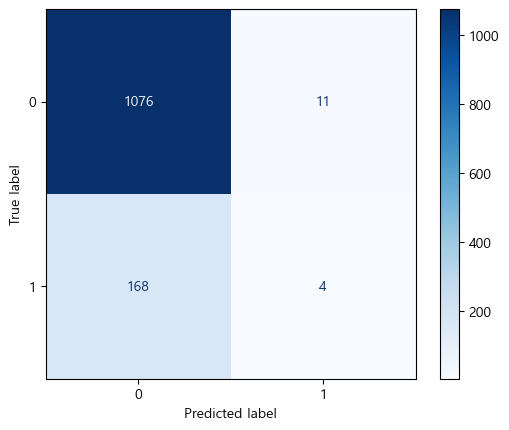

In [497]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 초기화
model = lgb.LGBMClassifier(random_state=42)

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

.